In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Prepare Gold Standard records

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# File paths
abstracts_file = '/content/drive/MyDrive/drugprot-data/training/drugprot_training_abstracts.tsv'
entities_file = '/content/drive/MyDrive/drugprot-data/training/drugprot_training_entities.tsv'
relations_file = '/content/drive/MyDrive/drugprot-data/training/drugprot_training_relations.tsv'

import pandas as pd
import numpy as np

# File paths
abstracts_file = '/content/drive/MyDrive/drugprot-data/training/drugprot_training_abstracts.tsv'
entities_file = 'entities_validation_with_abstracts.csv'
relations_file = 'relations_validation_with_abstracts.csv'

# Load the data
print("Loading datasets...")
abstracts_df = pd.read_csv(abstracts_file, sep='\t', header=None, names=['pmid', 'title', 'abstract'])
entities_df = pd.read_csv(entities_file)
relations_df = pd.read_csv(relations_file)

# Get unique article IDs (PMIDs) from validation sets
unique_pmids = pd.concat([entities_df['pmid'], relations_df['pmid']]).unique()

# Sample 200 unique article IDs
np.random.seed(42)  # for reproducibility
sampled_pmids = np.random.choice(unique_pmids, size=200, replace=False)

# Filter entities and relations based on sampled PMIDs
print("Filtering data for sampled articles...")
sampled_entities = entities_df[entities_df['pmid'].isin(sampled_pmids)]
sampled_relations = relations_df[relations_df['pmid'].isin(sampled_pmids)]

# Get abstracts for sampled PMIDs from the entire abstracts dataset
sampled_abstracts = abstracts_df[abstracts_df['pmid'].isin(sampled_pmids)]

# Save sampled data to CSV
print("Saving sampled data...")
sampled_entities.to_csv('sampled_entities_validation.csv', index=False)
sampled_relations.to_csv('sampled_relations_validation.csv', index=False)
sampled_abstracts.to_csv('sampled_abstracts_validation.csv', index=False)

# Print summary
print(f"Sampled {len(sampled_pmids)} unique articles.")
print(f"Sampled entities: {len(sampled_entities)}")
print(f"Sampled relations: {len(sampled_relations)}")
print(f"Sampled abstracts: {len(sampled_abstracts)}")
print("Files saved: sampled_entities_validation.csv, sampled_relations_validation.csv, sampled_abstracts_validation.csv")

# Optional: Check for data leakage
total_entities = len(entities_df)
total_relations = len(relations_df)
total_abstracts = len(abstracts_df)

print("\nData Leakage Analysis:")
print(f"Entities: {len(sampled_entities) / total_entities:.2%} of validation set")
print(f"Relations: {len(sampled_relations) / total_relations:.2%} of validation set")
print(f"Abstracts: {len(sampled_abstracts) / total_abstracts:.2%} of entire abstract set")

Loading data...
Splitting entity data...
Splitting relation data...
Getting abstracts for entity validation set...
Getting abstracts for relation validation set...
Saving validation sets...
Data preparation complete. Files saved: entities_validation_with_abstracts.csv, relations_validation_with_abstracts.csv


## Merge Entity Dataset and Relationship Dataset in DrugProt to Prepare for Validation

In [ ]:
import pandas as pd

def load_entities(file_path):
    columns = ['PMID', 'Term_ID', 'Entity_Type', 'Start_Offset', 'End_Offset', 'Entity_Text']
    df = pd.read_csv(file_path, sep='\t', header=None, names=columns)
    return df

def load_relations(file_path):
    columns = ['PMID', 'Relation', 'Arg1', 'Arg2']
    df = pd.read_csv(file_path, sep='\t', header=None, names=columns)
    return df

def extract_term_id(arg):
    return arg.split(':')[1]

def combine_datasets(entities_file, relations_file):
    # Load datasets
    entities_df = load_entities(entities_file)
    relations_df = load_relations(relations_file)

    # Extract term IDs from Arg1 and Arg2
    relations_df['Arg1_ID'] = relations_df['Arg1'].apply(extract_term_id)
    relations_df['Arg2_ID'] = relations_df['Arg2'].apply(extract_term_id)

    # Merge relations with entities for Arg1
    merged_df = pd.merge(relations_df, entities_df,
                         left_on=['PMID', 'Arg1_ID'],
                         right_on=['PMID', 'Term_ID'],
                         suffixes=('', '_arg1'))

    # Merge with entities for Arg2
    merged_df = pd.merge(merged_df, entities_df,
                         left_on=['PMID', 'Arg2_ID'],
                         right_on=['PMID', 'Term_ID'],
                         suffixes=('_arg1', '_arg2'))

    # Select and rename relevant columns
    result_df = merged_df[[
        'PMID', 'Relation',
        'Entity_Text_arg1', 'Entity_Type_arg1',
        'Entity_Text_arg2', 'Entity_Type_arg2'
    ]]
    result_df.columns = [
        'PMID', 'Relation',
        'Arg1_Text', 'Arg1_Type',
        'Arg2_Text', 'Arg2_Type'
    ]

    # Save to CSV
    result_df.to_csv(output_file, index=False)
    print("Combined dataset saved to")

    return result_df

# Usage
entities_file = '/content/drive/MyDrive/drugprot-data/training/drugprot_training_entities.tsv'
relations_file = '/content/drive/MyDrive/drugprot-data/training/drugprot_training_relations.tsv'
output_file = '/content/drive/MyDrive/ERP_Code/Validation/Drugprot_Combined_Dataset.csv'


combined_df = combine_datasets(entities_file, relations_file)
print(combined_df.head())

Combined dataset saved to
       PMID   Relation   Arg1_Text Arg1_Type          Arg2_Text Arg2_Type
0  23017395  INHIBITOR         EPA  CHEMICAL  HMG-CoA reductase    GENE-Y
1  23017395  INHIBITOR         DHA  CHEMICAL  HMG-CoA reductase    GENE-Y
2  12181427    PART-OF  amino acid  CHEMICAL               PDE3    GENE-Y
3  12181427    PART-OF  amino acid  CHEMICAL              PDE3A    GENE-Y
4  12181427  INHIBITOR   milrinone  CHEMICAL               PDE3    GENE-Y


## Sample Test Dataset from Validation Dataset

In [ ]:
import pandas as pd
import numpy as np

# File paths
abstracts_file = '/content/drive/MyDrive/drugprot-data/training/drugprot_training_abstracts.tsv'
entities_file = '/content/drive/MyDrive/drugprot-data/training/drugprot_training_entities.tsv'
relations_file = '/content/drive/MyDrive/ERP_Code/Validation/Drugprot_Combined_Dataset.csv'
entities_validation_file = '/content/drive/MyDrive/ERP_Code/Validation/entities_validation_with_abstracts.csv'
relations_validation_file = '/content/drive/MyDrive/ERP_Code/Validation/relations_validation_with_abstracts.csv'

# Load the complete datasets
print("Loading datasets...")
abstracts_df = pd.read_csv(abstracts_file, sep='\t', header=None, names=['pmid', 'title', 'abstract'])
entities_df = pd.read_csv(entities_file, sep='\t', header=None,
                          names=['pmid', 'entity_id', 'entity_type', 'start', 'end', 'text'])
relations_df = pd.read_csv(relations_file)

# Load validation datasets
entities_validation = pd.read_csv(entities_validation_file)
relations_validation = pd.read_csv(relations_validation_file)

# Get unique article IDs (PMIDs) from validation datasets
validation_pmids = pd.concat([entities_validation['pmid'], relations_validation['pmid']]).unique()

# Sample 200 unique article IDs from validation PMIDs
np.random.seed(42)  # for reproducibility
sampled_pmids = np.random.choice(validation_pmids, size=200, replace=False)

# Filter entities and relations from the complete datasets based on sampled PMIDs
print("Filtering data for sampled articles...")
sampled_entities = entities_df[entities_df['pmid'].isin(sampled_pmids)]
sampled_relations = relations_df[relations_df['PMID'].isin(sampled_pmids)]

# Get abstracts for sampled PMIDs
sampled_abstracts = abstracts_df[abstracts_df['pmid'].isin(sampled_pmids)]

# Save sampled data to CSV
print("Saving sampled data...")
sampled_entities.to_csv('/content/drive/MyDrive/ERP_Code/Validation/sampled_entities_from_validation.csv', index=False)
sampled_relations.to_csv('/content/drive/MyDrive/ERP_Code/Validation/sampled_relations_from_validation.csv', index=False)
sampled_abstracts.to_csv('/content/drive/MyDrive/ERP_Code/Validation/sampled_abstracts_from_validation.csv', index=False)

# Print summary
print(f"Sampled {len(sampled_pmids)} unique articles from validation set.")
print(f"Sampled entities: {len(sampled_entities)}")
print(f"Sampled relations: {len(sampled_relations)}")
print(f"Sampled abstracts: {len(sampled_abstracts)}")
print("Files saved: sampled_entities_from_validation.csv, sampled_relations_from_validation.csv, sampled_abstracts_from_validation.csv")

Loading datasets...
Filtering data for sampled articles...
Saving sampled data...
Sampled 200 unique articles from validation set.
Sampled entities: 5758
Sampled relations: 1336
Sampled abstracts: 200
Files saved: sampled_entities_from_validation.csv, sampled_relations_from_validation.csv, sampled_abstracts_from_validation.csv


In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

# Load the datasets
entities_df = pd.read_csv('/content/drive/MyDrive/ERP_Code/Validation/sampled_entities_from_validation.csv')
abstracts_df = pd.read_csv('/content/drive/MyDrive/ERP_Code/Validation/sampled_abstracts_from_validation.csv')

# Rename the 'PMID' column in the relationships dataset to match the abstracts dataset
# relationships_df = relationships_df.rename(columns={'PMID': 'pmid'})

# Merge the datasets on the 'pmid' field
merged_df = pd.merge(entities_df, abstracts_df[['pmid', 'title', 'abstract']], on='pmid', how='left')

# Check for any unmatched rows
unmatched = merged_df[merged_df['title'].isna()]
if not unmatched.empty:
    print(f"Warning: {len(unmatched)} rows in the relationship dataset did not find a match in the abstract dataset.")

# Preprocess the abstract text
def preprocess_abstract(abstract):
    # Tokenize the abstract into sentences
    sentences = sent_tokenize(abstract)
    return sentences

merged_df['preprocessed_abstract'] = merged_df['abstract'].apply(preprocess_abstract)

# Save the merged dataset
output_path = '/content/drive/MyDrive/ERP_Code/Validation/sampled_entities_with_abstracts.csv'
merged_df.to_csv(output_path, index=False)

print(f"Merged dataset saved to: {output_path}")

# Display the first few rows of the merged dataset
print(merged_df.head())

# Display some statistics
print("\nDataset Statistics:")
print(f"Total rows in entities dataset: {len(entities_df)}")
print(f"Total rows in abstract dataset: {len(abstracts_df)}")
print(f"Total rows in merged dataset: {len(merged_df)}")
print(f"Number of unique PMIDs in merged dataset: {merged_df['pmid'].nunique()}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Merged dataset saved to: /content/drive/MyDrive/ERP_Code/Validation/sampled_entities_with_abstracts.csv
       pmid entity_id entity_type  start   end                       text  \
0  23063590        T1    CHEMICAL    122   133                Cholesterol   
1  23063590        T2    CHEMICAL   1137  1148                cholesterol   
2  23063590        T3    CHEMICAL   1189  1214  hydroxymethylglutaryl CoA   
3  23063590        T4    CHEMICAL   1216  1223                    HMG CoA   
4  23063590        T5    CHEMICAL   1421  1437           artemisinic acid   

                                               title  \
0  Artemisinic acid inhibits melanogenesis throug...   
1  Artemisinic acid inhibits melanogenesis throug...   
2  Artemisinic acid inhibits melanogenesis throug...   
3  Artemisinic acid inhibits melanogenesis throug...   
4  Artemisinic acid inhibits melanogenesis throug...   

                                            abstract  \
0  Cholesterol is associated with the re

# Compare Entity Identification and Relationship Extraction Results

# Prepare Entity List for Dictionary Approach

In [ ]:
import pandas as pd
from tqdm import tqdm

def load_and_process_drugbank_data():
    print("Loading DrugBank data...")
    # Load drug data
    drug_df = pd.read_csv("/content/drive/MyDrive/ERP_Code/Validation/DrugBank_Drug_Vocabulary.csv")
    drug_entities = set(drug_df["Common name"].str.lower())
    for synonyms in tqdm(drug_df["Synonyms"].dropna(), desc="Processing drug synonyms"):
        drug_entities.update(syn.strip().lower() for syn in synonyms.split("|"))

    # Load gene data
    gene_df = pd.read_csv("/content/drive/MyDrive/ERP_Code/Validation/DrugBank_GENE_Dataset.csv")
    gene_entities = set(gene_df["Name"].str.lower())
    gene_entities.update(gene_df["Gene Name"].str.lower())

    return drug_entities, gene_entities

def create_combined_dictionary(output_file):
    drug_entities, gene_entities = load_and_process_drugbank_data()

    print("Creating combined dictionary...")
    with open(output_file, 'w', encoding='utf-8') as f:
        for entity in tqdm(drug_entities, desc="Writing chemical entities"):
            f.write(f"{entity}\tCHEMICAL\n")
        for entity in tqdm(gene_entities, desc="Writing gene entities"):
            f.write(f"{entity}\tGENE\n")

    print(f"Combined dictionary saved to {output_file}")
    print(f"Total entities: {len(drug_entities) + len(gene_entities)}")

if __name__ == "__main__":
    output_file = "/content/drive/MyDrive/ERP_Code/Validation/combined_drugbank_dictionary.txt"
    create_combined_dictionary(output_file)

Loading DrugBank data...


Processing drug synonyms: 100%|██████████| 10320/10320 [00:00<00:00, 340951.98it/s]


Creating combined dictionary...


Writing gene entities: 100%|██████████| 8481/8481 [00:00<00:00, 1172789.96it/s]

Combined dictionary saved to /content/drive/MyDrive/ERP_Code/Validation/combined_drugbank_dictionary.txt
Total entities: 56925


#NER Task---Compare Three Different Models on Test Dataset

## Using Dictional-based NER Model on the Test Dataset

In [ ]:
import pandas as pd
from tqdm import tqdm
import re
import nltk
from nltk.tokenize import word_tokenize
from collections import defaultdict

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'[\[\]\?\.]', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def load_dictionary(file_path):
    dictionary = defaultdict(set)
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            entity, entity_type = line.strip().split('\t')
            dictionary[entity_type].add(entity.lower())
    return dictionary

# Load your dictionary
entity_dict = load_dictionary('/content/drive/MyDrive/ERP_Code/Validation/combined_drugbank_dictionary.txt')

def dictionary_based_ner(text, dictionary):
    tokens = word_tokenize(text.lower())
    entities = []
    i = 0
    while i < len(tokens):
        for j in range(len(tokens), i, -1):
            phrase = ' '.join(tokens[i:j])
            for entity_type, entity_set in dictionary.items():
                if phrase in entity_set:
                    entities.append((phrase, entity_type))
                    i = j - 1
                    break
            else:
                continue
            break
        i += 1
    return entities

def process_dataset(df, ner_function, **kwargs):
    results = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        pmid = row['pmid']
        title = preprocess_text(row['title'])
        abstract = preprocess_text(row['abstract'])

        title_entities = ner_function(title, **kwargs)
        abstract_entities = ner_function(abstract, **kwargs)

        results.append({
            'pmid': pmid,
            'title': title,
            'abstract': abstract,
            'title_entities': title_entities,
            'abstract_entities': abstract_entities
        })
    return pd.DataFrame(results)

# Load test dataset
test_df = pd.read_csv('/content/drive/MyDrive/ERP_Code/Validation/sampled_abstracts_from_validation.csv')

# Process with dictionary-based approach
dict_results = process_dataset(test_df, dictionary_based_ner, dictionary=entity_dict)
dict_results.to_csv('dictionary_based_results.csv', index=False)

print("Entity extraction completed for all three approaches.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Configuration:
Number of labels: 7
ID to Label mapping: {0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4', 5: 'LABEL_5', 6: 'LABEL_6'}
Label to ID mapping: {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2, 'LABEL_3': 3, 'LABEL_4': 4, 'LABEL_5': 5, 'LABEL_6': 6}
Model Configuration:
Number of labels: 7
ID to Label mapping: {0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4', 5: 'LABEL_5', 6: 'LABEL_6'}
Label to ID mapping: {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2, 'LABEL_3': 3, 'LABEL_4': 4, 'LABEL_5': 5, 'LABEL_6': 6}


100%|██████████| 200/200 [01:41<00:00,  1.98it/s]

Entity extraction completed for all three approaches.


Dictionary-based models rely on predefined lists of entities (like medical terms, gene names, etc.) and usually offer high precision since they match exact terms. However, they often suffer from low recall because they cannot recognize variations of terms not explicitly listed in the dictionary.

## Using BioBERT Model on the Test Dataset

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
from tqdm import tqdm
import re
import ast

# Set up device and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "dmis-lab/biobert-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name).to(device)

# Ensure the model is in evaluation mode
model.eval()

def preprocess_text(text):
    if pd.isna(text) or text is None or not isinstance(text, str):
        return ""
    text = re.sub(r'[\[\]\?\.]', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def biobert_ner(text):
    text = preprocess_text(text)
    if not text:
        return []

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    predictions = torch.argmax(outputs.logits, dim=2)[0].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    processed_tokens = []
    for token, pred in zip(tokens, predictions):
        if token in ['[CLS]', '[SEP]', '[PAD]']:
            continue
        if token.startswith('##'):
            if processed_tokens:
                processed_tokens[-1] = (processed_tokens[-1][0] + token[2:], processed_tokens[-1][1])
        else:
            label = 'LABEL_1' if pred == 1 else 'LABEL_0'
            processed_tokens.append((token, label))

    return processed_tokens

def extract_entities(processed_text):
    entities = [token for token, label in processed_text if label == 'LABEL_1']
    return str(entities)  # Convert to string representation

def process_dataframe(df):
    tqdm.pandas()
    df['processed_title'] = df['title'].progress_apply(biobert_ner)
    df['title_entities'] = df['processed_title'].apply(extract_entities)
    df['processed_abstract'] = df['abstract'].progress_apply(biobert_ner)
    df['abstract_entities'] = df['processed_abstract'].apply(extract_entities)
    return df

# Main processing
if __name__ == '__main__':
    # Load the dataset
    df = pd.read_csv('/content/drive/MyDrive/ERP_Code/Validation/sampled_abstracts_from_validation.csv')

    # Process the dataframe
    processed_df = process_dataframe(df)

    # Convert processed columns to string representation
    processed_df['processed_title'] = processed_df['processed_title'].apply(str)
    processed_df['processed_abstract'] = processed_df['processed_abstract'].apply(str)

    # Select and reorder columns
    output_df = processed_df[['pmid', 'title', 'abstract', 'processed_title', 'title_entities', 'processed_abstract', 'abstract_entities']]

    # Save to CSV
    output_df.to_csv('biobert_results.csv', index=False)
    print("Processing completed. Results saved to 'revised_biobert_ner_results.csv'")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 200/200 [01:33<00:00,  2.15it/s]

Processing completed. Results saved to 'revised_biobert_ner_results.csv'


Conclusions:
* The model we're using (dmis-lab/biobert-v1.1) seems to be a generic NER model that has likely been fine-tuned on a dataset with only two classes. These classes might be something generic like "entity" versus "non-entity" or just a binary classification.
*This specific model is not suited for distinguishing between multiple biomedical entity types (like genes, diseases, chemicals, etc.) out of the box.

## Using Fine-Tuned BioBERT Model on the Test Dataset

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
import re
import spacy
from scispacy.abbreviation import AbbreviationDetector
from typing import List, Tuple, Union
import ast

# Load spaCy model for abbreviation expansion
nlp = spacy.load("en_core_sci_sm")

# Set up device and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/tokenizer")
ner_model = AutoModelForTokenClassification.from_pretrained("/content/drive/MyDrive/trained_ner_model").to(device)

# Ensure the model is in evaluation mode
ner_model.eval()

def preprocess_text(text):
    if pd.isna(text) or text is None or not isinstance(text, str):
        print(f"Invalid input text: {text}")
        return ""

    # Basic cleaning
    text = re.sub(r'[\[\]\?\.]', '', text)  # Remove specific punctuation
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'\s+', ' ', text).strip()  # Standardize whitespace

    return text

def clean_and_process_text(text):
    if pd.isna(text) or text is None or not isinstance(text, str):
        print(f"Invalid input for clean_and_process_text: {text}")
        return []

    # Clean and preprocess text
    text = preprocess_text(text)

    # Check if text is empty after preprocessing
    if not text:
        print(f"Text is empty after preprocessing: {text}")
        return []

    # Tokenize and get NER predictions
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = ner_model(**inputs)

    predictions = torch.argmax(outputs.logits, dim=2)[0].cpu().numpy()

    # Decode tokens and labels
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    id2label = ner_model.config.id2label

    # Reconstruct words and assign labels
    words = []
    labels = []
    current_word = ""
    current_label = "O"

    for token, pred in zip(tokens, predictions):
        if token in ['[CLS]', '[SEP]', '[PAD]']:
            if current_word:
                words.append(current_word)
                labels.append(current_label)
            current_word = ""
            current_label = "O"
            continue
        if token.startswith('##'):
            current_word += token[2:]
        else:
            if current_word:
                words.append(current_word)
                labels.append(current_label)
            current_word = token
            current_label = id2label[pred]

    if current_word:
        words.append(current_word)
        labels.append(current_label)

    return list(zip(words, labels))

def enhanced_process_ner_results(ner_results: Union[str, List[Tuple[str, str]]]) -> List[Tuple[str, str]]:
    entities = []
    current_entity = []
    current_label = None
    label_map = {
        'LABEL_1': 'CHEMICAL', 'LABEL_2': 'CHEMICAL',
        'LABEL_3': 'GENE-Y', 'LABEL_4': 'GENE-Y',
        'LABEL_5': 'GENE-N', 'LABEL_6': 'GENE-N'
    }

    def get_entity_type(label: str) -> str:
        return label_map.get(label, 'UNKNOWN')

    def clean_entity_text(text: str) -> str:
        text = re.sub(r'\s*-\s*', '-', text)
        text = re.sub(r'\s+([,.;:!?)])', r'\1', text)
        text = re.sub(r'(\()\s+', r'\1', text)
        return text.strip()

    def finalize_entity():
        if current_entity:
            entity_text = ' '.join(token for token, _ in current_entity)
            entity_text = clean_entity_text(entity_text)
            entity_label = get_entity_type(current_entity[0][1])
            entities.append((entity_text, entity_label))

    # Convert string representation of list to actual list if necessary
    if isinstance(ner_results, str):
        try:
            ner_results = ast.literal_eval(ner_results)
        except:
            print(f"Error parsing: {ner_results[:100]}...")  # Print first 100 chars for debugging
            return []

    # Ensure ner_results is a list of tuples
    if not isinstance(ner_results, list) or not all(isinstance(item, tuple) and len(item) == 2 for item in ner_results):
        print(f"Invalid format: {ner_results[:5]}...")  # Print first 5 items for debugging
        return []

    for token, label in ner_results:
        if label == 'LABEL_0':
            finalize_entity()
            current_entity = []
            current_label = None
        elif label in label_map:
            if not current_entity or get_entity_type(label) != current_label:
                finalize_entity()
                current_entity = [(token, label)]
                current_label = get_entity_type(label)
            else:
                current_entity.append((token, label))

    finalize_entity()
    return entities

def process_column(df, column_name):
    try:
        df[f'processed_{column_name}'] = df[column_name].apply(clean_and_process_text)
        # Remove rows where processed text is empty
        df = df[df[f'processed_{column_name}'].apply(len) > 0]
        # Apply enhanced processing
        df[f'{column_name}_entities'] = df[f'processed_{column_name}'].apply(enhanced_process_ner_results)
        return df
    except Exception as e:
        print(f"Error processing column {column_name}: {str(e)}")
        print(f"Problematic data in {column_name}:")
        print(df[column_name].head())
        return None

def is_hashable(value):
    try:
        hash(value)
        return True
    except:
        return False

# Main processing
if __name__ == '__main__':
    # Load test dataset
    test_df = pd.read_csv('/content/drive/MyDrive/ERP_Code/Validation/sampled_abstracts_from_validation.csv')

    '''
    # Print data info before processing
    print("Data info before processing:")
    print(df.info())
    '''

    # Process titles
    processed_titles = process_column(test_df, 'title')

    # Process abstracts
    processed_abstracts = process_column(test_df, 'abstract')

    # Combine titles and abstracts
    if processed_titles is not None and processed_abstracts is not None:
        # Identify columns to keep
        columns_to_keep = ['pmid', 'title', 'abstract', 'processed_title', 'title_entities', 'processed_abstract', 'abstract_entities']

        # Merge based on 'pmid' and keep only the desired columns
        combined_df = pd.merge(
            processed_titles[['pmid', 'title', 'processed_title', 'title_entities']],
            processed_abstracts[['pmid', 'abstract', 'processed_abstract', 'abstract_entities']],
            on='pmid',
            suffixes=('', '_y')
        )[columns_to_keep]

        # Save the combined processed data
        combined_df.to_csv('fine_tuned_biobert_results.csv', index=False)
        print("Processing completed. Combined data saved to 'fine_tuned_biobert_results.csv'")

        # Print data info after processing
        print("Data info after processing:")
        print(combined_df.info())
    else:
        print("Error: Could not combine processed titles and abstracts.")

Processing completed. Combined data saved to 'fine_tuned_biobert_results.csv'
Data info after processing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   pmid                200 non-null    int64 
 1   title               200 non-null    object
 2   abstract            200 non-null    object
 3   processed_title     200 non-null    object
 4   title_entities      200 non-null    object
 5   processed_abstract  200 non-null    object
 6   abstract_entities   200 non-null    object
dtypes: int64(1), object(6)
memory usage: 11.1+ KB
None


## Calculate Metrics to Comapre NER Performance of Different Models

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict

def load_ground_truth(file_path):
    df = pd.read_csv(file_path)
    ground_truth = defaultdict(list)
    for _, row in df.iterrows():
        ground_truth[row['pmid']].append({
            'text': row['text'],
            'type': row['entity_type'],
            'start': row['start'],
            'end': row['end']
        })
    return ground_truth

def load_dictionary_based(file_path):
    df = pd.read_csv(file_path)
    results = defaultdict(list)
    for _, row in df.iterrows():
        for source in ['title_entities', 'abstract_entities']:
            entities = eval(row[source])
            for entity, entity_type in entities:
                results[row['pmid']].append({
                    'text': entity,
                    'type': entity_type
                })
    return results

def load_fine_tuned_biobert(file_path):
    df = pd.read_csv(file_path)
    results = defaultdict(list)
    for _, row in df.iterrows():
        for source in ['title_entities', 'abstract_entities']:
            entities = eval(row[source])
            for entity, entity_type in entities:
                results[row['pmid']].append({
                    'text': entity,
                    'type': entity_type
                })
    return results

def load_biobert(file_path):
    df = pd.read_csv(file_path)
    results = defaultdict(list)
    for _, row in df.iterrows():
        for source in ['title_entities', 'abstract_entities']:
            entities = eval(row[source])
            for entity in entities:
                results[row['pmid']].append({
                    'text': entity,
                    'type': None
                })
    return results

def remove_duplicates(entities):
    seen = set()
    return [e for e in entities if not (e['text'] in seen or seen.add(e['text']))]

def calculate_metrics(true_positives, false_positives, false_negatives):
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

def evaluate_entity_recognition(ground_truth, model_results):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for pmid in ground_truth:
        gt_entities = remove_duplicates(ground_truth[pmid])
        model_entities = remove_duplicates(model_results.get(pmid, []))

        gt_texts = set(e['text'].lower() for e in gt_entities)
        model_texts = set(e['text'].lower() for e in model_entities)

        true_positives += len(gt_texts.intersection(model_texts))
        false_positives += len(model_texts - gt_texts)
        false_negatives += len(gt_texts - model_texts)

    return calculate_metrics(true_positives, false_positives, false_negatives)

def evaluate_entity_type_classification(ground_truth, model_results):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for pmid in ground_truth:
        gt_entities = remove_duplicates(ground_truth[pmid])
        model_entities = remove_duplicates(model_results.get(pmid, []))

        for gt_entity in gt_entities:
            gt_text = gt_entity['text'].lower()
            gt_type = gt_entity['type']

            matching_model_entities = [e for e in model_entities if e['text'].lower() == gt_text]

            if matching_model_entities:
                model_type = matching_model_entities[0]['type']
                if gt_type == 'CHEMICAL' and model_type == 'CHEMICAL':
                    true_positives += 1
                elif gt_type in ['GENE-Y', 'GENE-N'] and model_type in ['GENE', 'GENE-Y', 'GENE-N']:
                    true_positives += 1
                else:
                    false_positives += 1
            else:
                false_negatives += 1

        for model_entity in model_entities:
            model_text = model_entity['text'].lower()
            if not any(e['text'].lower() == model_text for e in gt_entities):
                false_positives += 1

    return calculate_metrics(true_positives, false_positives, false_negatives)

# Load data
ground_truth = load_ground_truth('/content/drive/MyDrive/ERP_Code/Validation/sampled_entities_from_validation.csv')
dictionary_based = load_dictionary_based('dictionary_based_results.csv')
fine_tuned_biobert = load_fine_tuned_biobert('fine_tuned_biobert_results.csv')
biobert = load_biobert('biobert_results.csv')

# Evaluate entity recognition
print("Entity Recognition Performance:")
for model_name, model_results in [
    ("Dictionary-based", dictionary_based),
    ("Fine-tuned BioBERT", fine_tuned_biobert),
    ("BioBERT", biobert)
]:
    precision, recall, f1 = evaluate_entity_recognition(ground_truth, model_results)
    print(f"{model_name}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print()

# Evaluate entity type classification
print("Entity Type Classification Performance:")
for model_name, model_results in [
    ("Dictionary-based", dictionary_based),
    ("Fine-tuned BioBERT", fine_tuned_biobert)
]:
    precision, recall, f1 = evaluate_entity_type_classification(ground_truth, model_results)
    print(f"{model_name}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print()

Entity Recognition Performance:
Dictionary-based:
  Precision: 0.4922
  Recall: 0.2733
  F1-score: 0.3514

Fine-tuned BioBERT:
  Precision: 0.7202
  Recall: 0.7556
  F1-score: 0.7375

BioBERT:
  Precision: 0.0501
  Recall: 0.3495
  F1-score: 0.0876

Entity Type Classification Performance:
Dictionary-based:
  Precision: 0.4926
  Recall: 0.2754
  F1-score: 0.3533

Fine-tuned BioBERT:
  Precision: 0.7166
  Recall: 0.7584
  F1-score: 0.7369



#Relationship Extraction---Compare Three Different Models on the Test Dataset

In [ ]:
import pandas as pd
relation_df = pd.read_csv('/content/drive/MyDrive/ERP_Code/Validation/sampled_relationships_with_abstracts.csv')

## Using ML-based Model, BioBERT model on the Test Dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import sent_tokenize
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

nltk.download('punkt')

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    grouped_data = df.groupby('pmid').apply(lambda x: {
        'entities': x[['entity_id', 'entity_type', 'text']].to_dict('records'),
        'title': x['title'].iloc[0],
        'abstract': x['abstract'].iloc[0],
        'preprocessed_abstract': eval(x['preprocessed_abstract'].iloc[0])
    }).reset_index()
    grouped_data.columns = ['pmid', 'data']
    return grouped_data

def rule_based_pair_extraction(grouped_data):
    results = []
    for _, row in tqdm(grouped_data.iterrows(), total=len(grouped_data), desc="Rule-based extraction"):
        pmid = row['pmid']
        data = row['data']
        entities = data['entities']
        sentences = data['preprocessed_abstract']

        for i, entity1 in enumerate(entities):
            for j, entity2 in enumerate(entities[i+1:], start=i+1):
                for sentence in sentences:
                    if entity1['text'].lower() in sentence.lower() and entity2['text'].lower() in sentence.lower():
                        results.append({
                            'pmid': pmid,
                            'entity1': entity1['text'],
                            'entity2': entity2['text'],
                            'entity1_type': entity1['entity_type'],
                            'entity2_type': entity2['entity_type'],
                            'sentence': sentence
                        })
                        break  # Stop after finding the first co-occurrence
    return pd.DataFrame(results)

def ml_based_pair_extraction(grouped_data):
    results = []
    for _, row in tqdm(grouped_data.iterrows(), total=len(grouped_data), desc="ML-based extraction"):
        pmid = row['pmid']
        data = row['data']
        entities = data['entities']
        abstract = ' '.join(data['preprocessed_abstract'])

        entity_docs = [f"{e['text']} {abstract}" for e in entities]
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(entity_docs)
        similarities = cosine_similarity(X)

        for i in range(len(entities)):
            for j in range(i+1, len(entities)):
                if similarities[i][j] > 0.5:  # Adjust this threshold as needed
                    results.append({
                        'pmid': pmid,
                        'entity1': entities[i]['text'],
                        'entity2': entities[j]['text'],
                        'entity1_type': entities[i]['entity_type'],
                        'entity2_type': entities[j]['entity_type'],
                        'similarity_score': similarities[i][j]
                    })

    return pd.DataFrame(results)

def biobert_pair_extraction(grouped_data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
    model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1").to(device)

    results = []
    for _, row in tqdm(grouped_data.iterrows(), total=len(grouped_data), desc="BioBERT extraction"):
        pmid = row['pmid']
        data = row['data']
        entities = data['entities']
        abstract = ' '.join(data['preprocessed_abstract'])

        for i, entity1 in enumerate(entities):
            for j, entity2 in enumerate(entities[i+1:], start=i+1):
                input_text = f"{entity1['text']} [SEP] {entity2['text']} [SEP] {abstract}"
                inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)

                with torch.no_grad():
                    outputs = model(**inputs)

                # Use the [CLS] token embedding as the representation of the pair
                pair_embedding = outputs.last_hidden_state[:, 0, :]

                # Calculate a simple score (e.g., the magnitude of the embedding)
                score = torch.norm(pair_embedding).item()

                if score > 10:  # Adjust this threshold as needed
                    results.append({
                        'pmid': pmid,
                        'entity1': entity1['text'],
                        'entity2': entity2['text'],
                        'entity1_type': entity1['entity_type'],
                        'entity2_type': entity2['entity_type'],
                        'biobert_score': score
                    })

    return pd.DataFrame(results)

if __name__ == "__main__":
    file_path = '/content/drive/MyDrive/ERP_Code/Validation/sampled_entities_with_abstracts.csv'
    grouped_data = load_and_preprocess_data(file_path)

    # Rule-based pair extraction
    rule_based_pairs = rule_based_pair_extraction(grouped_data)
    rule_based_pairs.to_csv('/content/drive/MyDrive/ERP_Code/Validation/rule_based_pairs.csv', index=False)
    print("Rule-based potential entity pairs saved.")

    # ML-based pair extraction
    ml_based_pairs = ml_based_pair_extraction(grouped_data)
    ml_based_pairs.to_csv('/content/drive/MyDrive/ERP_Code/Validation/ml_based_pairs.csv', index=False)
    print("ML-based potential entity pairs saved.")

    # BioBERT-based pair extraction
    biobert_pairs = biobert_pair_extraction(grouped_data)
    biobert_pairs.to_csv('/content/drive/MyDrive/ERP_Code/Validation/biobert_pairs.csv', index=False)
    print("BioBERT-based potential entity pairs saved.")

    # Print statistics
    print("\nRule-based Results Statistics:")
    print(f"Total potential pairs: {len(rule_based_pairs)}")
    print(f"Number of unique PMIDs: {rule_based_pairs['pmid'].nunique()}")

    print("\nML-based Results Statistics:")
    print(f"Total potential pairs: {len(ml_based_pairs)}")
    print(f"Number of unique PMIDs: {ml_based_pairs['pmid'].nunique()}")

    print("\nBioBERT-based Results Statistics:")
    print(f"Total potential pairs: {len(biobert_pairs)}")
    print(f"Number of unique PMIDs: {biobert_pairs['pmid'].nunique()}")

    # Compare the methods
    all_methods = pd.merge(rule_based_pairs, ml_based_pairs, on=['pmid', 'entity1', 'entity2'], how='outer')
    all_methods = pd.merge(all_methods, biobert_pairs, on=['pmid', 'entity1', 'entity2'], how='outer')

    print("\nComparison of methods:")
    print(f"Total unique pairs found by any method: {len(all_methods)}")
    print(f"Pairs found by all three methods: {len(all_methods.dropna())}")
    print(f"Pairs found only by rule-based method: {len(all_methods[all_methods['sentence'].notna() & all_methods['similarity_score'].isna() & all_methods['biobert_score'].isna()])}")
    print(f"Pairs found only by ML-based method: {len(all_methods[all_methods['sentence'].isna() & all_methods['similarity_score'].notna() & all_methods['biobert_score'].isna()])}")
    print(f"Pairs found only by BioBERT-based method: {len(all_methods[all_methods['sentence'].isna() & all_methods['similarity_score'].isna() & all_methods['biobert_score'].notna()])}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Rule-based extraction: 100%|██████████| 200/200 [00:00<00:00, 491.46it/s]


Rule-based potential entity pairs saved.


ML-based extraction: 100%|██████████| 200/200 [00:01<00:00, 141.92it/s]


ML-based potential entity pairs saved.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

BioBERT extraction: 100%|██████████| 200/200 [22:50<00:00,  6.85s/it]


BioBERT-based potential entity pairs saved.

Rule-based Results Statistics:
Total potential pairs: 69035
Number of unique PMIDs: 200

ML-based Results Statistics:
Total potential pairs: 101292
Number of unique PMIDs: 200

BioBERT-based Results Statistics:
Total potential pairs: 101292
Number of unique PMIDs: 200

Comparison of methods:
Total unique pairs found by any method: 56550330
Pairs found by all three methods: 56405441
Pairs found only by rule-based method: 0
Pairs found only by ML-based method: 0
Pairs found only by BioBERT-based method: 0


## Using Fine-tuned BioBERT Model on Test Dataset

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# Define relationship types
RELATIONSHIP_TYPES = [
    'INHIBITOR', 'DIRECT-REGULATOR', 'SUBSTRATE', 'ACTIVATOR', 'INDIRECT-UPREGULATOR',
    'INDIRECT-DOWNREGULATOR', 'ANTAGONIST', 'PRODUCT-OF', 'PART-OF', 'AGONIST',
    'AGONIST-ACTIVATOR', 'SUBSTRATE_PRODUCT-OF', 'AGONIST-INHIBITOR'
]

# Load the tokenizer and model
tokenizer_path = '/content/drive/MyDrive/tokenizer'
model_path = '/content/drive/MyDrive/trained_relation_model'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=len(RELATIONSHIP_TYPES))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

class DrugTargetDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = f"{item['title']} {item['abstract']}"
        entity1 = item['entity1']
        entity2 = item['entity2']

        combined_text = f"{text} [SEP] {entity1} [SEP] {entity2}"
        encoding = self.tokenizer.encode_plus(
            combined_text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'entity1': entity1,
            'entity2': entity2,
            'entity1_type': item['entity1_type'],
            'entity2_type': item['entity2_type'],
            'pmid': item['pmid']
        }

def clean_relationships(df):
    print(f"Initial shape: {df.shape}")

    # Ensure pmid is string
    df['pmid'] = df['pmid'].astype(str)
    print(f"After ensuring pmid is string shape: {df.shape}")

    # Standardize entity names
    df['entity1'] = df.apply(lambda row: standardize_entity(row['entity1'], row['entity1_type']), axis=1)
    df['entity2'] = df.apply(lambda row: standardize_entity(row['entity2'], row['entity2_type']), axis=1)
    print(f"After standardizing entities shape: {df.shape}")

    # Remove rows with blank entities
    df = df.dropna(subset=['entity1', 'entity2'])
    print(f"After removing blank entities shape: {df.shape}")

    # Create a directional pair (maintain original order)
    df['entity_pair'] = df.apply(lambda row: (row['entity1'], row['entity2']), axis=1)

    # Group by pmid and sort within each group by confidence
    df_sorted = df.sort_values(['pmid', 'confidence'], ascending=[True, False])

    # Drop duplicates within each pmid group, preserving directionality
    df_cleaned = df_sorted.drop_duplicates(subset=['pmid', 'entity_pair', 'relationship'], keep='first')
    print(f"After removing duplicates shape: {df_cleaned.shape}")

    # Drop temporary columns
    df_cleaned = df_cleaned.drop(columns=['entity_pair'])

    return df_cleaned

def standardize_entity(entity, entity_type):
    if pd.isna(entity) or entity.strip() == '':
        return None

    entity = str(entity).strip()

    if entity_type == 'CHEMICAL':
        return entity.lower()  # Changed to lowercase for CHEMICAL entities
    else:
        return entity  # Other entity types remain unchanged

def extract_relationships(model, dataloader, device):
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting relationships", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=1)
            predicted_relationships = torch.argmax(probabilities, dim=1)

            for i, pred in enumerate(predicted_relationships):
                relationship = RELATIONSHIP_TYPES[pred.item()]
                all_predictions.append({
                    'pmid': batch['pmid'][i],
                    'entity1': batch['entity1'][i],
                    'entity1_type': batch['entity1_type'][i],
                    'entity2': batch['entity2'][i],
                    'entity2_type': batch['entity2_type'][i],
                    'relationship': relationship,
                    'confidence': probabilities[i][pred].item()
                })

    return pd.DataFrame(all_predictions)

import pandas as pd
from itertools import combinations

def create_entity_pairs(group):
    pairs = []
    entities = list(zip(group['text'], group['entity_type']))
    for (entity1, type1), (entity2, type2) in combinations(entities, 2):
        if type1 in ['CHEMICAL', 'GENE-Y', 'GENE-N'] and type2 in ['CHEMICAL', 'GENE-Y', 'GENE-N']:
            pairs.append({
                'pmid': group['pmid'].iloc[0],
                'title': group['title'].iloc[0],
                'abstract': group['abstract'].iloc[0],
                'entity1': entity1,
                'entity1_type': type1,
                'entity2': entity2,
                'entity2_type': type2
            })
    return pairs

def process_full_dataset(df):
    print("Column names in the dataset:")
    print(df.columns)

    print("\nFirst few rows of the dataset:")
    print(df.head())

    # Group by PMID and create entity pairs
    grouped = df.groupby('pmid')
    all_pairs = []
    for _, group in grouped:
        all_pairs.extend(create_entity_pairs(group))

    print(f"Found {len(all_pairs)} valid entity pairs to process")

    if len(all_pairs) == 0:
        print("No valid entity pairs found. Please check your data structure and column names.")
        return pd.DataFrame()  # Return an empty DataFrame if no valid pairs are found

    data = pd.DataFrame(all_pairs)
    dataset = DrugTargetDataset(data.to_dict('records'), tokenizer, max_length=256)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

    predictions = extract_relationships(model, dataloader, device)

    cleaned_predictions = clean_relationships(predictions)

    return cleaned_predictions

# Main execution
# Load your dataset
df_test = pd.read_csv('/content/drive/MyDrive/ERP_Code/Validation/sampled_entities_with_abstracts.csv')

print(f"Starting relationship extraction on test dataset with {len(df_test)} rows")
final_results = process_full_dataset(df_test)

if not final_results.empty:
    # Save the final results
    output_path = '/content/drive/MyDrive/ERP_Code/Validation/fine_tuned_biobert_pairs.csv'
    final_results.to_csv(output_path, index=False)
    print(f"Relationship extraction completed. Results saved to {output_path}")
    print(f"Total relationships extracted: {len(final_results)}")

    # Analysis of results
    print("\nAnalysis of results:")
    print(f"Number of unique articles: {final_results['pmid'].nunique()}")
    print("\nTop 10 most frequent relationships:")
    print(final_results['relationship'].value_counts().head(10))
else:
    print("No results to save or analyze. Please check your input data and the warnings above.")

Starting relationship extraction on test dataset with 5758 rows
Column names in the dataset:
Index(['pmid', 'entity_id', 'entity_type', 'start', 'end', 'text', 'title',
       'abstract', 'preprocessed_abstract'],
      dtype='object')

First few rows of the dataset:
       pmid entity_id entity_type  start   end                       text  \
0  23063590        T1    CHEMICAL    122   133                Cholesterol   
1  23063590        T2    CHEMICAL   1137  1148                cholesterol   
2  23063590        T3    CHEMICAL   1189  1214  hydroxymethylglutaryl CoA   
3  23063590        T4    CHEMICAL   1216  1223                    HMG CoA   
4  23063590        T5    CHEMICAL   1421  1437           artemisinic acid   

                                               title  \
0  Artemisinic acid inhibits melanogenesis throug...   
1  Artemisinic acid inhibits melanogenesis throug...   
2  Artemisinic acid inhibits melanogenesis throug...   
3  Artemisinic acid inhibits melanogenesis th

Initial shape: (101292, 7)
After ensuring pmid is string shape: (101292, 7)
After standardizing entities shape: (101292, 7)
After removing blank entities shape: (101292, 7)
After removing duplicates shape: (27569, 8)
Relationship extraction completed. Results saved to /content/drive/MyDrive/ERP_Code/Validation/fine_tuned_biobert_pairs.csv
Total relationships extracted: 27569

Analysis of results:
Number of unique articles: 200

Top 10 most frequent relationships:
relationship
SUBSTRATE_PRODUCT-OF      6201
INDIRECT-DOWNREGULATOR    4071
DIRECT-REGULATOR          3427
SUBSTRATE                 2688
ANTAGONIST                2163
INDIRECT-UPREGULATOR      2127
AGONIST-ACTIVATOR         2049
AGONIST                   1676
ACTIVATOR                 1615
INHIBITOR                 1371
Name: count, dtype: int64


## Compare Relationship Extraction Score Distributions

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Metric distributions plot saved as 'metric_distributions.png'


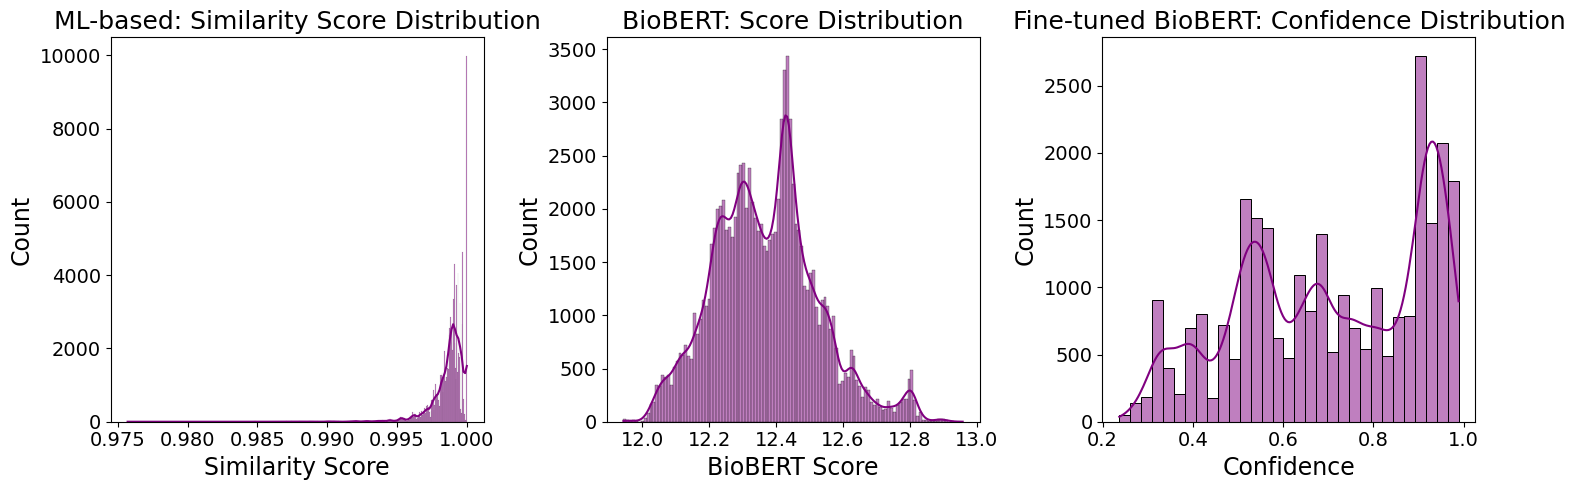

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import sent_tokenize
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')

def deduplicate_pairs(df):
    return df.drop_duplicates(subset=['pmid', 'entity1', 'entity2'])

def plot_metric_distributions(ML_df, biobert_df,fine_tuned_biobert_df):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.histplot(data=rule_based, x='similarity_score', kde=True, color = 'purple')
    plt.title('ML-based: Similarity Score Distribution', fontsize=18)
    plt.xlabel('Similarity Score', fontsize=17)
    plt.ylabel('Count', fontsize=17)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.subplot(1, 3, 2)
    sns.histplot(data=ml_based, x='biobert_score', kde=True, color = 'purple')
    plt.title('BioBERT: Score Distribution', fontsize=18)
    plt.xlabel('BioBERT Score', fontsize=17)
    plt.ylabel('Count', fontsize=17)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.subplot(1, 3, 3)
    sns.histplot(data=biobert, x='confidence', kde=True, color = 'purple')
    plt.title('Fine-tuned BioBERT: Confidence Distribution', fontsize=18)
    plt.xlabel('Confidence', fontsize=17)
    plt.ylabel('Count', fontsize=17)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    #plt.savefig('relationship_extraction_score_distributions.png)
    #plt.close()

if __name__ == "__main__":
    # Drop duplicates within each pmid group
    #rule_based_df = pd.read_csv('/content/drive/MyDrive/ERP_Code/Validation/rule_based_pairs.csv')
    ML_df = pd.read_csv('/content/drive/MyDrive/ERP_Code/Validation/ml_based_pairs.csv')
    biobert_df = pd.read_csv('/content/drive/MyDrive/ERP_Code/Validation/biobert_pairs.csv')
    fine_tuned_biobert_df = pd.read_csv('/content/drive/MyDrive/ERP_Code/Validation/fine_tuned_biobert_pairs.csv')
    #deduplicate_pairs(rule_based_df)
    deduplicate_pairs(ML_df)
    deduplicate_pairs(biobert_df)
    deduplicate_pairs(fine_tuned_biobert_df)

    #rule_based_df.to_csv('/content/drive/MyDrive/ERP_Code/Validation/rule_based_pairs.csv')
    ML_df.to_csv('/content/drive/MyDrive/ERP_Code/Validation/ml_based_pairs.csv')
    biobert_df.to_csv('/content/drive/MyDrive/ERP_Code/Validation/biobert_pairs.csv')
    fine_tuned_biobert_df.to_csv('/content/drive/MyDrive/ERP_Code/Validation/fine_tuned_biobert_pairs.csv')

    # Plot metric distributions
    plot_metric_distributions(ML_df, biobert_df,fine_tuned_biobert_df)
    print("Metric distributions plot saved as 'metric_distributions.png'")